<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw22/hw2p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
from google.colab import drive
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torch.optim import Adam

In [148]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
path_ = './drive/My Drive/hw2_q2.pkl'

In [0]:
with open(path_, 'rb') as fin:
    dataset = pickle.load(fin)

X_train = torch.FloatTensor(dataset['train']).permute(0, 3, 1, 2)[:160, :, :, :]
X_test = torch.FloatTensor(dataset['test']).permute(0, 3, 1, 2)[:32, :, :, :]

In [0]:
def plot_losses(loss_train, loss_val):
    plt.plot(loss_train, label = "train")
    plt.plot(loss_val, label = "val")
    plt.legend()
    plt.show()

In [0]:
def log_det(t):
    return torch.log(t).sum(dim=1, keepdim=True)

In [0]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return F.relu(self.net(x) + x)

In [0]:
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            ResBlock(out_channels, out_channels),
            ResBlock(out_channels, out_channels),
            ResBlock(out_channels, out_channels),
            ResBlock(out_channels, out_channels),
            nn.Conv2d(out_channels, 2 * in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.net(x)      

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, mask, in_channels, out_channels):
        super(AffineCoupling, self).__init__()
        self.mask = mask.clone()
        self.resnet = ResNet(in_channels, out_channels)

    def accept(self, x):
        z = self.mask * x
        log_s, t = self.resnet(z).split(z.shape[1], dim=1)
        log_s = torch.tanh(log_s)

        return z, log_s, t

    def forward(self, x):
        z, log_s, t = self.accept(x)

        return z + (1 - self.mask) * (torch.exp(log_s) * x + t), (log_s * (1.0 - self.mask)).flatten(1).sum(dim=1, keepdim=True)

    def reverse(self, x):
        z, log_s, t = self.accept(x)
        
        return z + (1 - self.mask) * (x - t) / torch.exp(log_s)

In [0]:
class ActNorm(nn.Module):
    def __init__(self, c, h, w):
        super(ActNorm, self).__init__()
        self.w = nn.Parameter(torch.ones([1, c, h, w]))
        self.b = nn.Parameter(torch.zeros([1, c, h, w]))

    def forward(self, x):
        return x * self.w + self.b, torch.log(self.w.abs() + 1e-8).flatten(1).sum(dim=1, keepdim=True)

    def reverse(self, x):
        return (x - self.b) / self.w

In [0]:
class RealNVP(nn.Module):
    def __init__(self, in_dim, h, w):
        super(RealNVP, self).__init__()
        self.prior = Normal(0, 1)

        self.layers1 = nn.ModuleList()
        mask = self.checkerboard_mask(in_dim, h, w)
        for _ in range(4):
            self.layers1.append(AffineCoupling(mask, in_dim, 32))
            self.layers1.append(ActNorm(in_dim, h, w))
            mask = 1.0 - mask
        in_dim, h, w = in_dim * 4, h // 2, w // 2
        self.layers2 = nn.ModuleList()
        mask = self.channel_split_mask(in_dim, h, w)
        for _ in range(3):
            self.layers2.append(AffineCoupling(mask, in_dim, 32))
            self.layers2.append(ActNorm(in_dim, h, w))
            mask = 1.0 - mask
        self.layers3 = nn.ModuleList()
        mask = self.checkerboard_mask(in_dim, h, w)
        for _ in range(3):
            self.layers3.append(AffineCoupling(mask, in_dim, 32))
            self.layers3.append(ActNorm(in_dim, h, w))
            mask = 1.0 - mask
        in_dim, h, w = in_dim * 4, h // 2, w // 2
        self.layers4 = nn.ModuleList()
        mask = self.channel_split_mask(in_dim, h, w)
        for _ in range(3):
            self.layers4.append(AffineCoupling(mask, in_dim, 32))
            self.layers4.append(ActNorm(in_dim, h, w))
            mask = 1.0 - mask
        self.layers5 = nn.ModuleList()
        mask = self.checkerboard_mask(in_dim, h, w)
        for i in range(3):
            self.layers5.append(AffineCoupling(mask, in_dim, 32))
            self.layers5.append(ActNorm(in_dim, h, w))
            mask = 1.0 - mask

    def forward(self, x):
        alpha = 0.05
        deq = alpha + (1.0 - alpha) * x / 4.0
        diag1 = (torch.ones_like(x) * (1.0 - alpha) / 4.0).abs().flatten(start_dim=1)
        diag2 = (1.0 / deq + 1.0 / (1.0 - deq)).abs().flatten(start_dim=1)
        x, logdet = torch.log(deq) - torch.log(1.0 - deq), log_det(diag1 + 1e-8) + log_det(diag2 + 1e-8)

        for layer in self.layers1:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        x = self.squeeze(x)
        for layer in self.layers2:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers3:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        x = self.squeeze(x)
        for layer in self.layers4:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers5:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        return self.unsqueeze(self.unsqueeze(x)), logdet

    def log_prob(self, x):
        z, logdet = self.forward(x)
        log_pz = self.prior.log_prob(z).flatten(start_dim=1).sum(dim=1, keepdim=True)
        return (-log_pz - logdet).mean()

    def reverse(self, x):
        alpha = 0.05
        x = self.squeeze(self.squeeze(x))
        for layer in reversed(self.layers5):
            x = layer.reverse(x)
        for layer in reversed(self.layers4):
            x = layer.reverse(x)
        x = self.unsqueeze(x)
        for layer in reversed(self.layers3):
            x = layer.reverse(x)
        for layer in reversed(self.layers2):
            x = layer.reverse(x)
        x = self.unsqueeze(x)
        for layer in reversed(self.layers1):
            x = layer.reverse(x)
        
        return 4.0 * ((torch.exp(x) / (torch.exp(x) + 1)) - alpha) / (1.0 - alpha)
    
    def squeeze(self, x):
        n, c, h, w = x.shape
        return F.unfold(x, (2, 2), stride=2).reshape(n, 4 * c, h // 2, w // 2)

    def unsqueeze(self, x):
        n, c, h, w = x.shape
        return F.fold(x.reshape(n, c, -1), (h * 2, w * 2), (2, 2), stride=2)

    def checkerboard_mask(self, c, h, w):
        a = np.ones([1, c, h, w], dtype=np.bool)
        b = np.ones([1, c, h, w], dtype=np.bool)
        a[:, :, np.arange(1, h, 2), :] = False
        b[:, :, :, np.arange(0, w, 2)] = False
        return torch.tensor(a ^ b, dtype=torch.float32, device=device)


    def channel_split_mask(self, c, h, w):
        mask = torch.zeros([1, c, h, w], dtype=torch.float32, device=device)
        idx = t = np.arange(0, c // 4) * 4
        idx = np.stack((idx, idx + 1), axis=1).reshape(-1)
        mask[:, idx, :, :] = 1.0
        return mask

In [0]:
batch_size = 256
epochs_num = 600

In [0]:
model = RealNVP(3, 32, 32).to(device)

In [0]:
def train():
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
    optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=0)

    loss_train, loss_val = [], []
    for epoch in range(epochs_num):
        if epoch % 20 == 0:
            print(int(epoch / 20))

        model.train()
        losses_ = []
        for batch in train_loader:
            batch = batch.to(device)
            loss = model.log_prob(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses_.append(loss.data.cpu().numpy())
        loss_train.append(np.mean(losses_))
        
        model.eval()
        losses_ = []
        with torch.no_grad():
            for item in val_loader:
                batch = batch.to(device)
                val_loss = model.log_prob(batch)
                losses_.append(val_loss.data.cpu().numpy())
            loss_val.append(np.mean(losses_))

    return loss_train, loss_val

In [164]:
loss_train, loss_val = train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


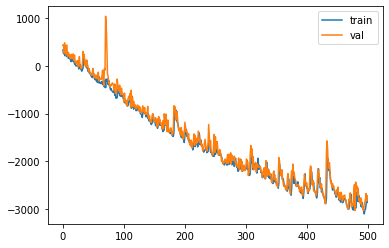

In [165]:
plot_losses(loss_train[100:], loss_val[100:])

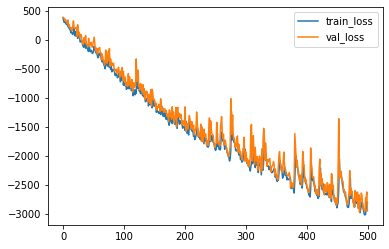

In [24]:
plot_losses(loss_train[100:], loss_val[100:])

In [0]:
_ = model.eval()

In [0]:
def interpolate(model):
    left_faces = X_train[[2, 4, 0]].to(device)
    right_faces = X_train[[3, 6, 1]].to(device)

    imgs = [[], [], []]
    with torch.no_grad():
        for i in range(3):
            left, b = left_faces[i].unsqueeze(0), right_faces[i].unsqueeze(0)
            z_left, _ = model(left)
            z_right, _ = model(b)
            ts = [j / 7 for j in range(8)]
            for t in ts:
                x = model.reverse((1 - t) * z_left + t * z_right)
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                imgs[i].append(np.clip(x[:, :, [2, 0, 1]] / 3, 0, 1))

    f, ax = plt.subplots(3, 8)
    f.set_figheight(4)
    f.set_figwidth(15)
    for i in range(3):
        for j in range(8):
            ax[i, j].imshow(imgs[i][j])
    plt.show()

In [0]:
def draw_images(images):
    f, ax = plt.subplots(images.shape[0], images.shape[1])
    f.set_figheight(15)
    f.set_figwidth(15)
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            ax[i, j].imshow(images[i][j])
    plt.show()


def draw_samples(model):
    z = Normal(0, 1).sample([100, 3, 32, 32]).to(device)
    images = model.reverse(z).permute(0, 2, 3, 1).cpu().detach().numpy()
    images = np.clip(images[:, :, :, [2, 0, 1]] / 3, 0, 1).reshape(10, 10, images.shape[1], images.shape[2], images.shape[3])
    draw_images(images)

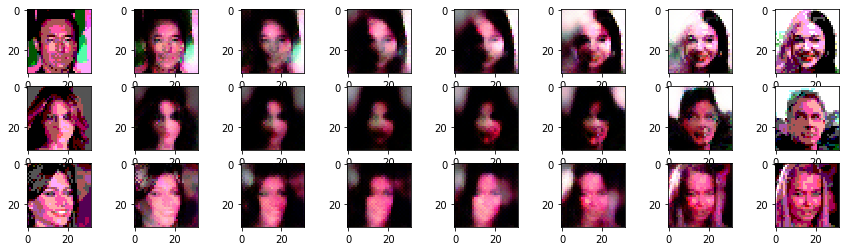

In [169]:
interpolate(model)

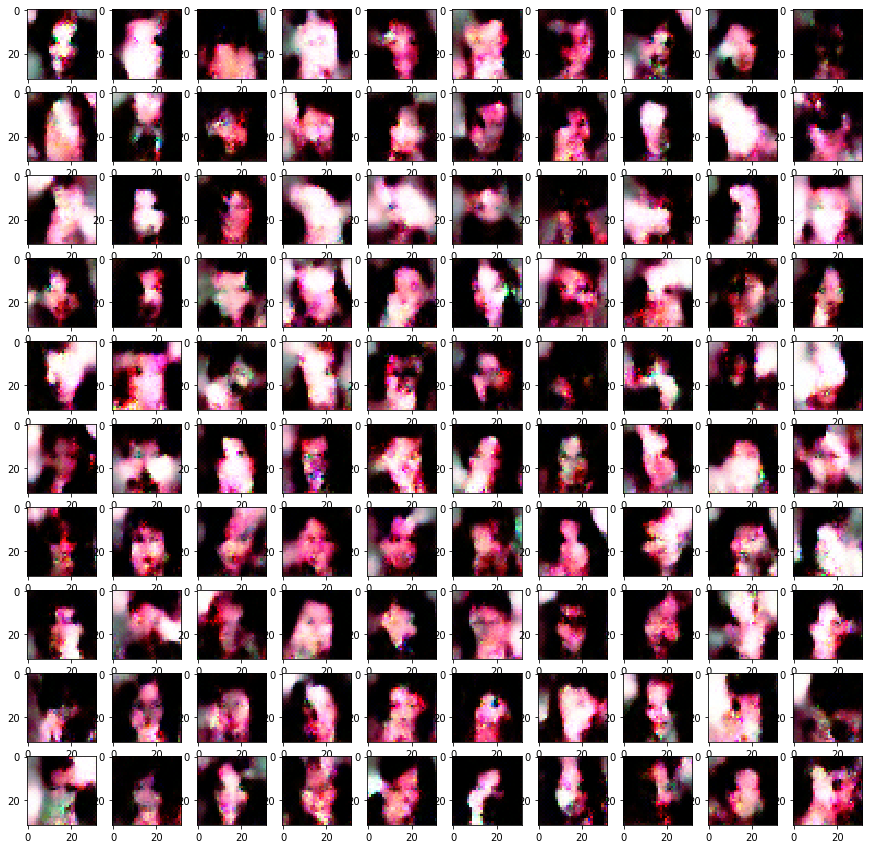

In [174]:
draw_samples(model)

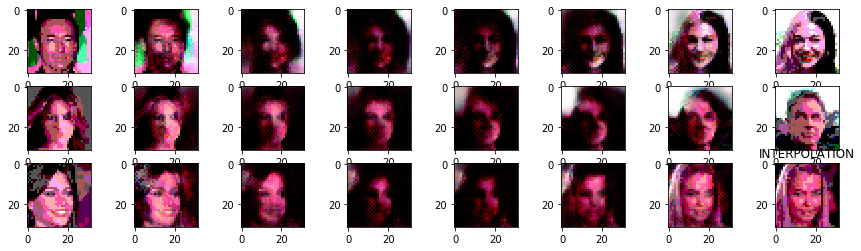

In [31]:
interpolate(model)

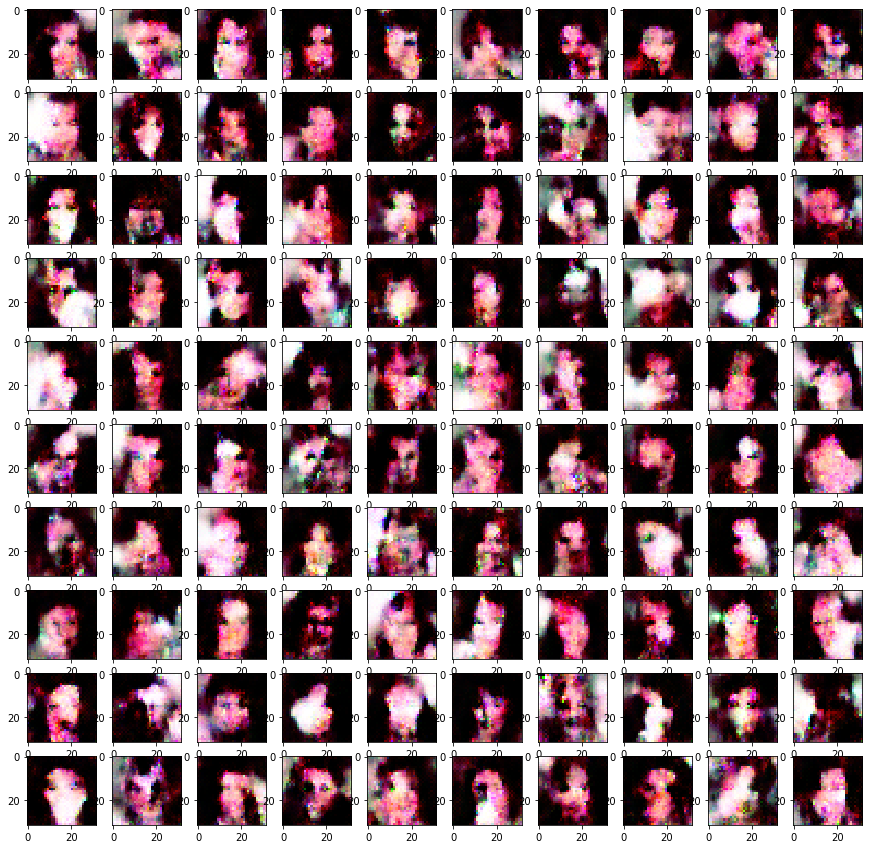

In [29]:
draw_samples(model)